In [ ]:
from core.meta.py import meta
class RouteGenerator(object):

    def __init__(self):
        """
        Function to publish routing request
        """
        self.topic_name = "/atlas/routing_request"
        self.pm = meta.PubMaster(self.topic_name) # 问题3：meta 相当于node?  pm is a instance of PubMaster Class

    def pub_route_data(self, poses, lane_ids): ## capnp的操作
        assert(len(poses) > 1)
        route_msg = meta.new_message("routingRequest") ## 根据capnp 的定义创建空的消息
        request = route_msg.routingRequest
        
        # 往消息中添加信息
        waypoints = request.init("waypoint",len(poses))
        for index, waypoint in enumerate(waypoints):
            waypoint.pose.x, waypoint.pose.y, waypoint.pose.z = poses[index]

        blacklistedLanes = request.init("blacklistedLane", len(lane_segments))
        for index, blacklistedLane in enumerate(blacklistedLanes):
            blacklistedLane.id, blacklistedLane.startS, blacklistedLane.endS = lane_segments[index]

        print("request:", request)
        
        # 发送消息
        self.pm.send(route_msg)


if __name__ == "__main__":

    meta.init("route_sim") # 问题1：初始化的作用是干什么？为什么输入是“route_sim”?
    if meta.ok():          # 问题2：is_shutdown()是什么意思，运行前not shutdown, 运行结束后也是not shutdown
        print("meta is ok")
    else:
        print("meta is not ready")
    route_generator = RouteGenerator() # 生成一个对象，并初始化
    print("RouteGenerator is initialized")
    route_waypoints = [# start
                       [395575.6613549063, 3416112.622005837, 16.82308641605909],
                       # after the first zebra crossing on Ganlan Road
                       [395535.02166326245, 3418171.828532504, 16.81578460530033],
                       # after bus station in Huchenghuan Road
                       [395117.7056792814, 3417066.7271003793, 16.041096687316895],
                       # virtual lane at junction of Huchenghuan Road and Guzong Road
                       [395524.4119071244, 3416659.5195476464, 15.968566265621071],
                       # virtual lane after second U turn
                       [395367.9160542466, 3416026.8673207345, 15.762357712891768],
                       # end
                       [395575.1945712591, 3416112.237363302, 16.82215515954192]]
    blacklisted_lanes = ["2243_0_-1", "2899_0_-1"]
    route_generator.pub_route_data(route_waypoints, blacklisted_lanes)
    if meta.is_shutdown():
        print("mate is shutdown")
    else:
        print("mate is not shutdown")
        
    ## 问题4：atlas/localization/pose 如何获取

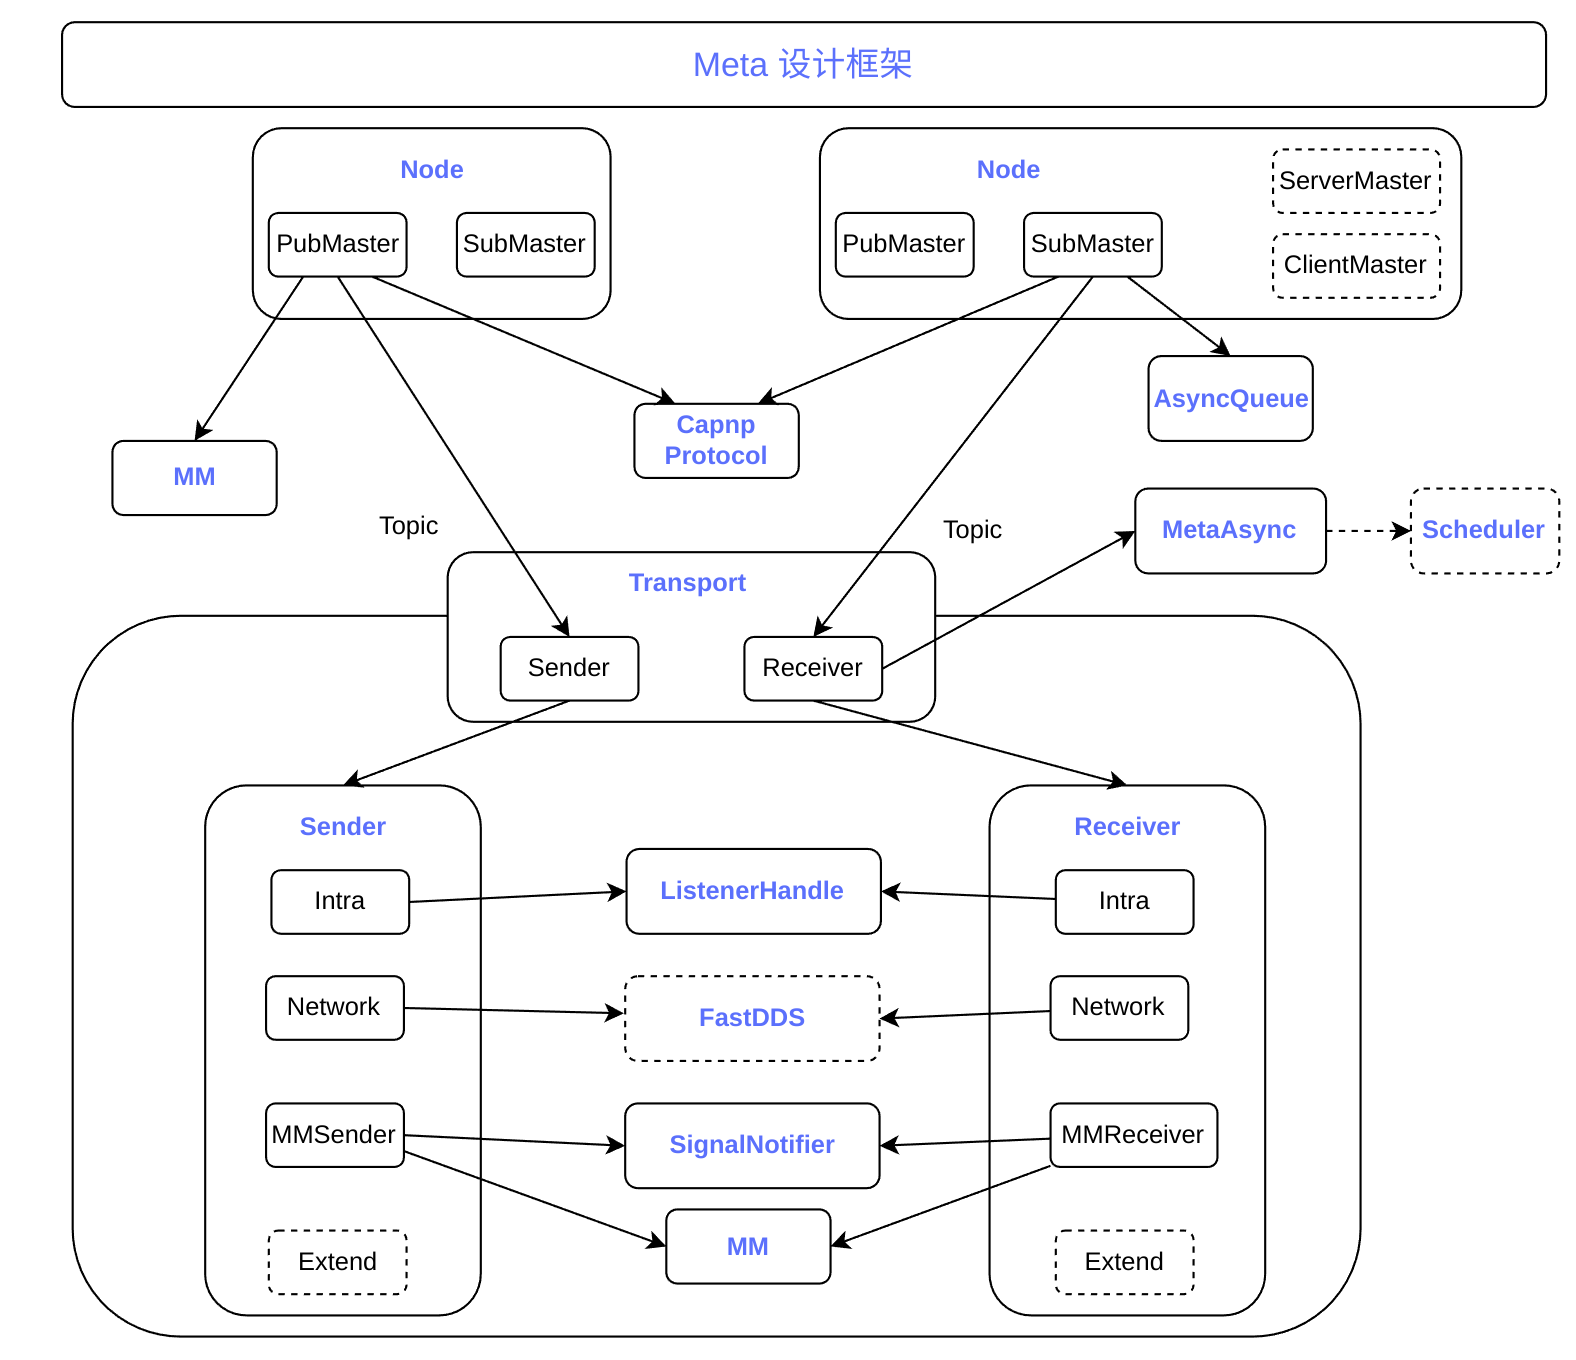

In [ ]:
#!/usr/bin/env python3

"""Module for init environment."""

import ctypes
import importlib
import os
import sys
import time

from typing import Optional, Union
from enum import IntEnum
import capnp

capnp.remove_import_hook()

PY_CALLBACK_TYPE = ctypes.CFUNCTYPE(ctypes.c_int, ctypes.c_int, ctypes.c_int)
PY_SUB_CALLBACK_TYPE = ctypes.CFUNCTYPE(ctypes.c_int, ctypes.c_char_p)

# init vars
wrapper_lib_path = os.path.abspath(os.path.join(os.path.dirname(__file__), "internal"))
sys.path.append(wrapper_lib_path)

_META = importlib.import_module("_meta_wrapper")

messages = capnp.load("modules/capnp/messages.capnp", imports=sys.path)


##
# @brief init meta environment.
# @param module_name Used as the log file name.
#
# @return Success is True, otherwise False.
def init(module_name="meta_py"):
    """init meta environment."""
    return _META.py_init(1, sys.argv[0], module_name)


# init is ok
def ok():
    """meta envi is ok."""
    return _META.py_ok()


# shutdown
def shutdown():
    """shutdown meta envi."""
    return _META.py_shutdown()


# is_shutdown
def is_shutdown():
    """meta is shutdown."""
    return _META.py_is_shutdown()


# waitforshutdown
def waitforshutdown():
    """wait until the meta is shutdown."""
    while ok():
        time.sleep(0.2)


# //////////////////////////////class//////////////////////////////
# capnp messages
def new_message(
    union_var: Optional[str] = None, size: Optional[int] = None
) -> capnp.lib.capnp._DynamicStructBuilder:
    """new capnp message."""
    dat = messages.Event.new_message()
    dat.logTime = time.time_ns()
    dat.valid = True
    if union_var is not None:
        if size is None:
            dat.init(union_var)
        else:
            dat.init(union_var, size)
    return dat


# OptionalMode Enum Class
class OptionalMode(IntEnum):
    """OptionalMode Enum."""

    HYBRID = 0
    SHM = 1
    INTRA = 2
    UNKNOWN = 3
    NETWORK = 4
    ENV = 5
    UDP = 6


# PubMaster Class
class PubMaster(object):
    """Meta pub master."""

    def __init__(self, topic_name, mode: OptionalMode = OptionalMode.SHM):
        """Meta pub master init."""
        self.topic_name = topic_name
        self.pubMaster = _META.py_PubMaster(topic_name, mode)

    def send(self, dat: Union[bytes, capnp.lib.capnp._DynamicStructBuilder]) -> None:
        """Send capnp msg data."""
        if not isinstance(dat, bytes):
            data_bytes = dat.to_bytes()
            _META.py_PubMaster_Send(self.pubMaster, data_bytes)


# SubMaster Class
class SubMaster(object):
    """Meta sub master."""

    def __init__(self):
        """Meta sub master init."""
        self.subMaster = _META.py_SubMaster()
        self.fun_reader_cb = None
        self.user_callback = None
        self.fun_sub_cb = None

        self.fun_sub_cb = PY_CALLBACK_TYPE(self.sub_callback)
        f_ptr = ctypes.cast(self.fun_sub_cb, ctypes.c_void_p).value
        _META.py_SubMaster_Callback(self.subMaster, f_ptr)

    def sub_callback(self, data, size):
        """Used to solve the problem that Python cannot receive the kill signal.."""
        return True

    def reader_callback(self, name):
        """Sub callback msg.."""
        data = _META.py_SubMaster_Read(self.subMaster, name.decode("utf-8"))
        msg = messages.Event.from_bytes(data)
        self.user_callback(msg)
        return True

    def subscribe(
        self,
        topic,
        callback,
        conflate: bool = False,
        mode: OptionalMode = OptionalMode.SHM,
        size: int = 1,
    ):
        """Add subscribe topic.."""
        self.user_callback = callback
        self.fun_reader_cb = PY_SUB_CALLBACK_TYPE(self.reader_callback)
        f_ptr = ctypes.cast(self.fun_reader_cb, ctypes.c_void_p).value
        if conflate is True:
            size = 1
        _META.py_SubMaster_Subscribe(self.subMaster, topic, mode, size, f_ptr)

    def spinAsync(self):
        """spinAsync.."""
        _META.py_SubMaster_SpinAsync(self.subMaster)

    def spin(self):
        """spin.."""
        while ok() is True:
            self.spinOnce()
            time.sleep(0.001)

    def spinOnce(self):
        """spinOnce.."""
        _META.py_SubMaster_SpinOnce(self.subMaster)
